In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch 
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F



from utils.utils import *
from utils.display import *
from utils.model_setup import CoinDataset

from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Name:", torch.cuda.get_device_name(0))  # Print the name of the GPU
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

train_folder = 'data/train_coins3'
masks_folder = 'data/train_masks3'

/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


GPU is not available, using CPU instead


# 3. Classification

In [2]:
labels_names = ['5CHF', '2CHF', '1CHF', '0.5CHF', '0.2CHF', '0.1CHF', '0.05CHF',
       '2EUR', '1EUR', '0.5EUR', '0.2EUR', '0.1EUR', '0.05EUR', '0.02EUR',
       '0.01EUR', 'OOD']

images = load_images_from_folder(train_folder,resize=False)
masks = load_images_from_folder(masks_folder,resize=False)

data = pd.read_csv(train_folder+'/labels.csv')
labels = data['labels'].values
y = [labels_names.index(label) for label in labels]

x_train, x_val, y_train, y_val, masks_train, masks_val = train_test_split(images, y, masks, seed=42)

In [3]:
x_train = [x_train[i] for i in range(len(x_train)) if y_train[i]!=15]
masks_train = [masks_train[i] for i in range(len(masks_train)) if y_train[i]!=15]
y_train = [y_train[i] for i in range(len(y_train)) if y_train[i]!=15]


x_val = [x_val[i] for i in range(len(x_val)) if y_val[i]!=15]
masks_val = [masks_val[i] for i in range(len(masks_val)) if y_val[i]!=15]
y_val = [y_val[i] for i in range(len(y_val)) if y_val[i]!=15]


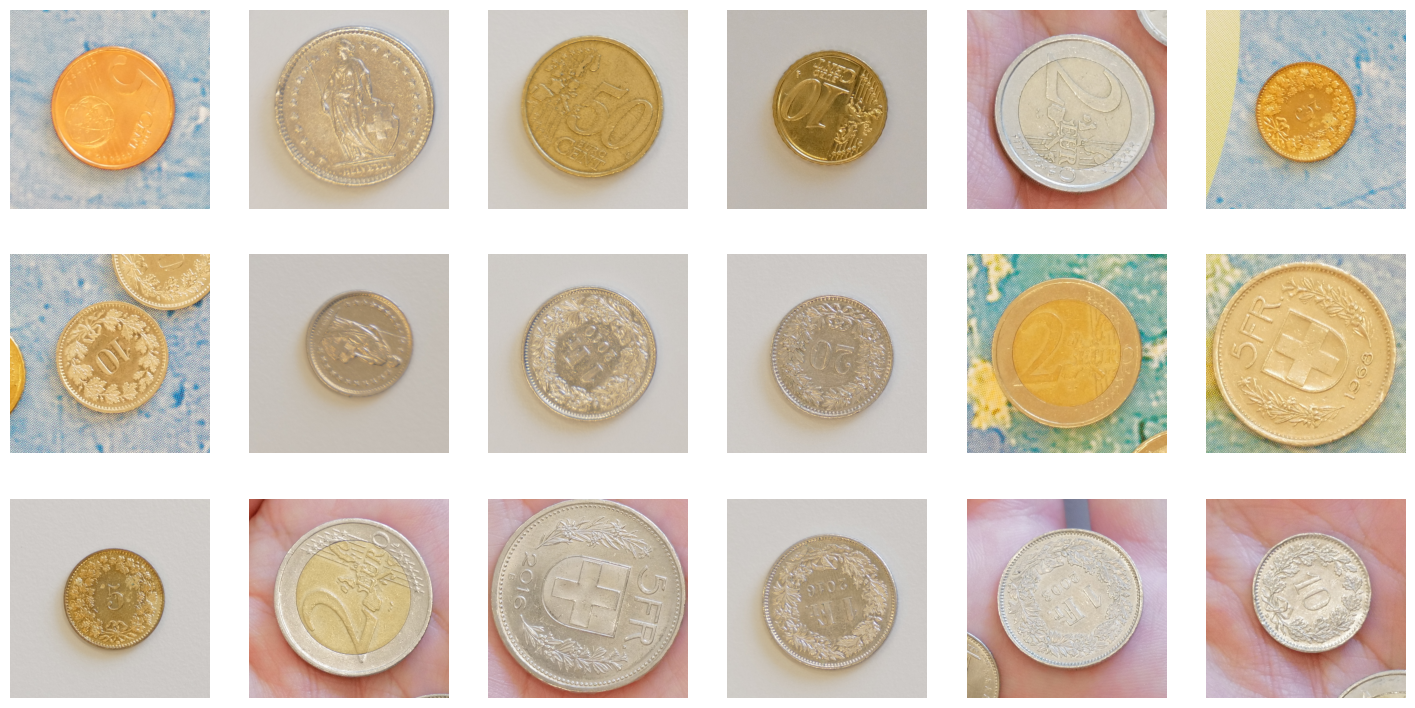

In [4]:
x_sample = x_train[0:18]
y_sample = [y_train[i] for i in range(18)]

plot_coins(x_sample, y_sample)

In [5]:
# Load pre-trained ResNet-50 model
model = models.resnet50(weights="IMAGENET1K_V2")
augment = True

def init(module, weight_init, bias_init, gain=1):
    '''
    This function provides weight and bias initializations for linear layers.
    '''
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

init_ = lambda m: init(m, nn.init.xavier_normal_, lambda x: nn.init.constant_(x, 0), np.sqrt(2))

In [6]:
num_classes = 15  # number of coin types
batch_size = 16
random.seed(42)

# Replace the last fully connected layer
model.fc = torch.nn.Sequential(init_(nn.Linear(model.fc.in_features, num_classes*10)),
                               nn.BatchNorm1d(num_classes*10),
                               nn.ReLU(),
                               nn.Dropout(0.5),
                               init_(nn.Linear(num_classes*10, num_classes)))


# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True

# Assuming you have a directory with 'train' and 'val' subdirectories
train_dataset = CoinDataset(x_train, y_train, masks_train, is_validation=False, augment=True)
valid_dataset = CoinDataset(x_val, y_val, masks_val, is_validation=True)


train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [7]:
save_path = 'data/model400b.ckpt'

#read best_val_accuracy.ckpt
if os.path.exists('data/best_val_accuracy.ckpt'):
    overall_best_val_accuracy = torch.load('data/best_val_accuracy.ckpt')
    print(f'Validation accuracy to beat: {overall_best_val_accuracy}')
else:
    overall_best_val_accuracy = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # Optimize only the last layer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# Train the model
model.train()
n_epochs = 20

best_val_accuracy = 0

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}', unit='batch')

    losses = []
    correct_train = 0
    total_train = 0

    for batch_idx, (features, labels) in enumerate(progress_bar):

        optimizer.zero_grad() #set gradient to zero before starting
    
        
        preds = model(features)
        loss = F.cross_entropy(preds, labels)

        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(F.softmax(preds, dim=1).data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        train_accuracy =  correct_train / total_train

        losses.append(loss.item())
        epoch_train_loss = np.mean(losses)

        progress_bar.set_postfix(loss=epoch_train_loss, train_accuracy=train_accuracy)


        if batch_idx == len(train_loader) - 1:
            # Calculate validation set accuracy
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images,labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            val_accuracy =  correct_val / total_val

            if val_accuracy >= best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_epoch = epoch+1
                torch.save(model.state_dict(), save_path)
                if best_val_accuracy >= overall_best_val_accuracy:
                    overall_best_val_accuracy = best_val_accuracy
                    torch.save(model, 'data/best_model.pth')
                    torch.save(best_val_accuracy, 'data/best_val_accuracy.ckpt')
                    print(f'This model is your best model with accuracy: {best_val_accuracy} at epoch: {best_epoch}')

        #     # Save metrics
            train_losses.append(epoch_train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            # Update progress bar postfix with validation set accuracy
            progress_bar.set_postfix(loss=epoch_train_loss, train_accuracy=train_accuracy, val_accuracy=val_accuracy)    

    scheduler.step()  

Validation accuracy to beat: 0.8529411764705882


Epoch 3/20:  18%|█▊        | 3/17 [01:08<05:18, 22.77s/batch, loss=1.18, train_accuracy=0.625]


KeyboardInterrupt: 

In [ ]:
print(f"Best validation accuracy: {best_val_accuracy} at epoch {best_epoch}")

Best validation accuracy: 0.8529411764705882 at epoch 16


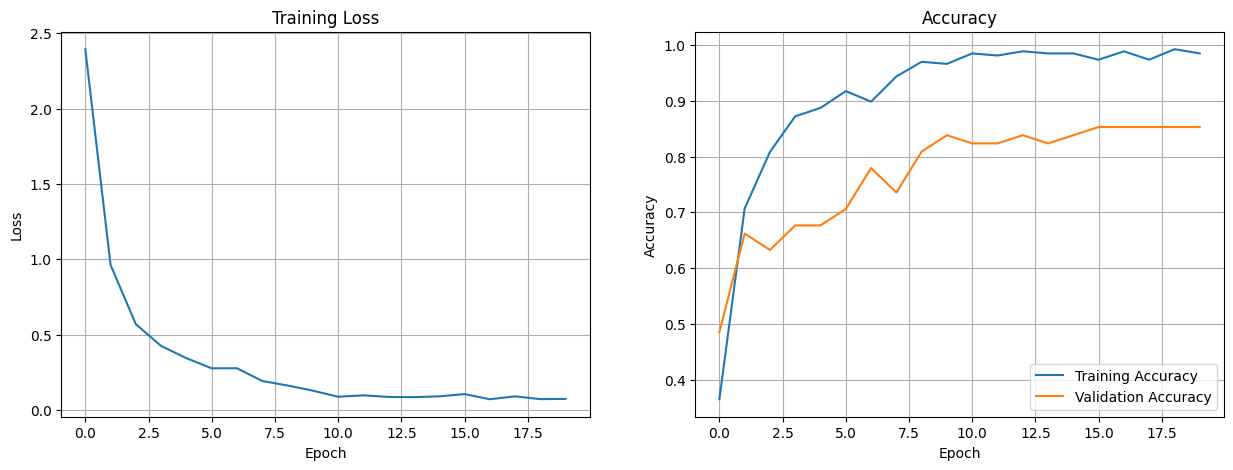

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()

axs[1].plot(train_accuracies, label='Training Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()
plt.show()


# Observe Predictions

In [ ]:
# model = torch.load('data/best_model.pth')

y_pred = []
# Set the model to evaluation mode
model.eval()

# Iterate over the test dataset and make predictions
for images, labels in valid_loader:
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted class index
    _, predicted = torch.max(outputs, 1)
    
    # Convert the predicted class index to the corresponding label
    # predicted_label = labels_names[predicted.item()]
    y_pred.extend(predicted.cpu().numpy())
    
    # Print the predicted label

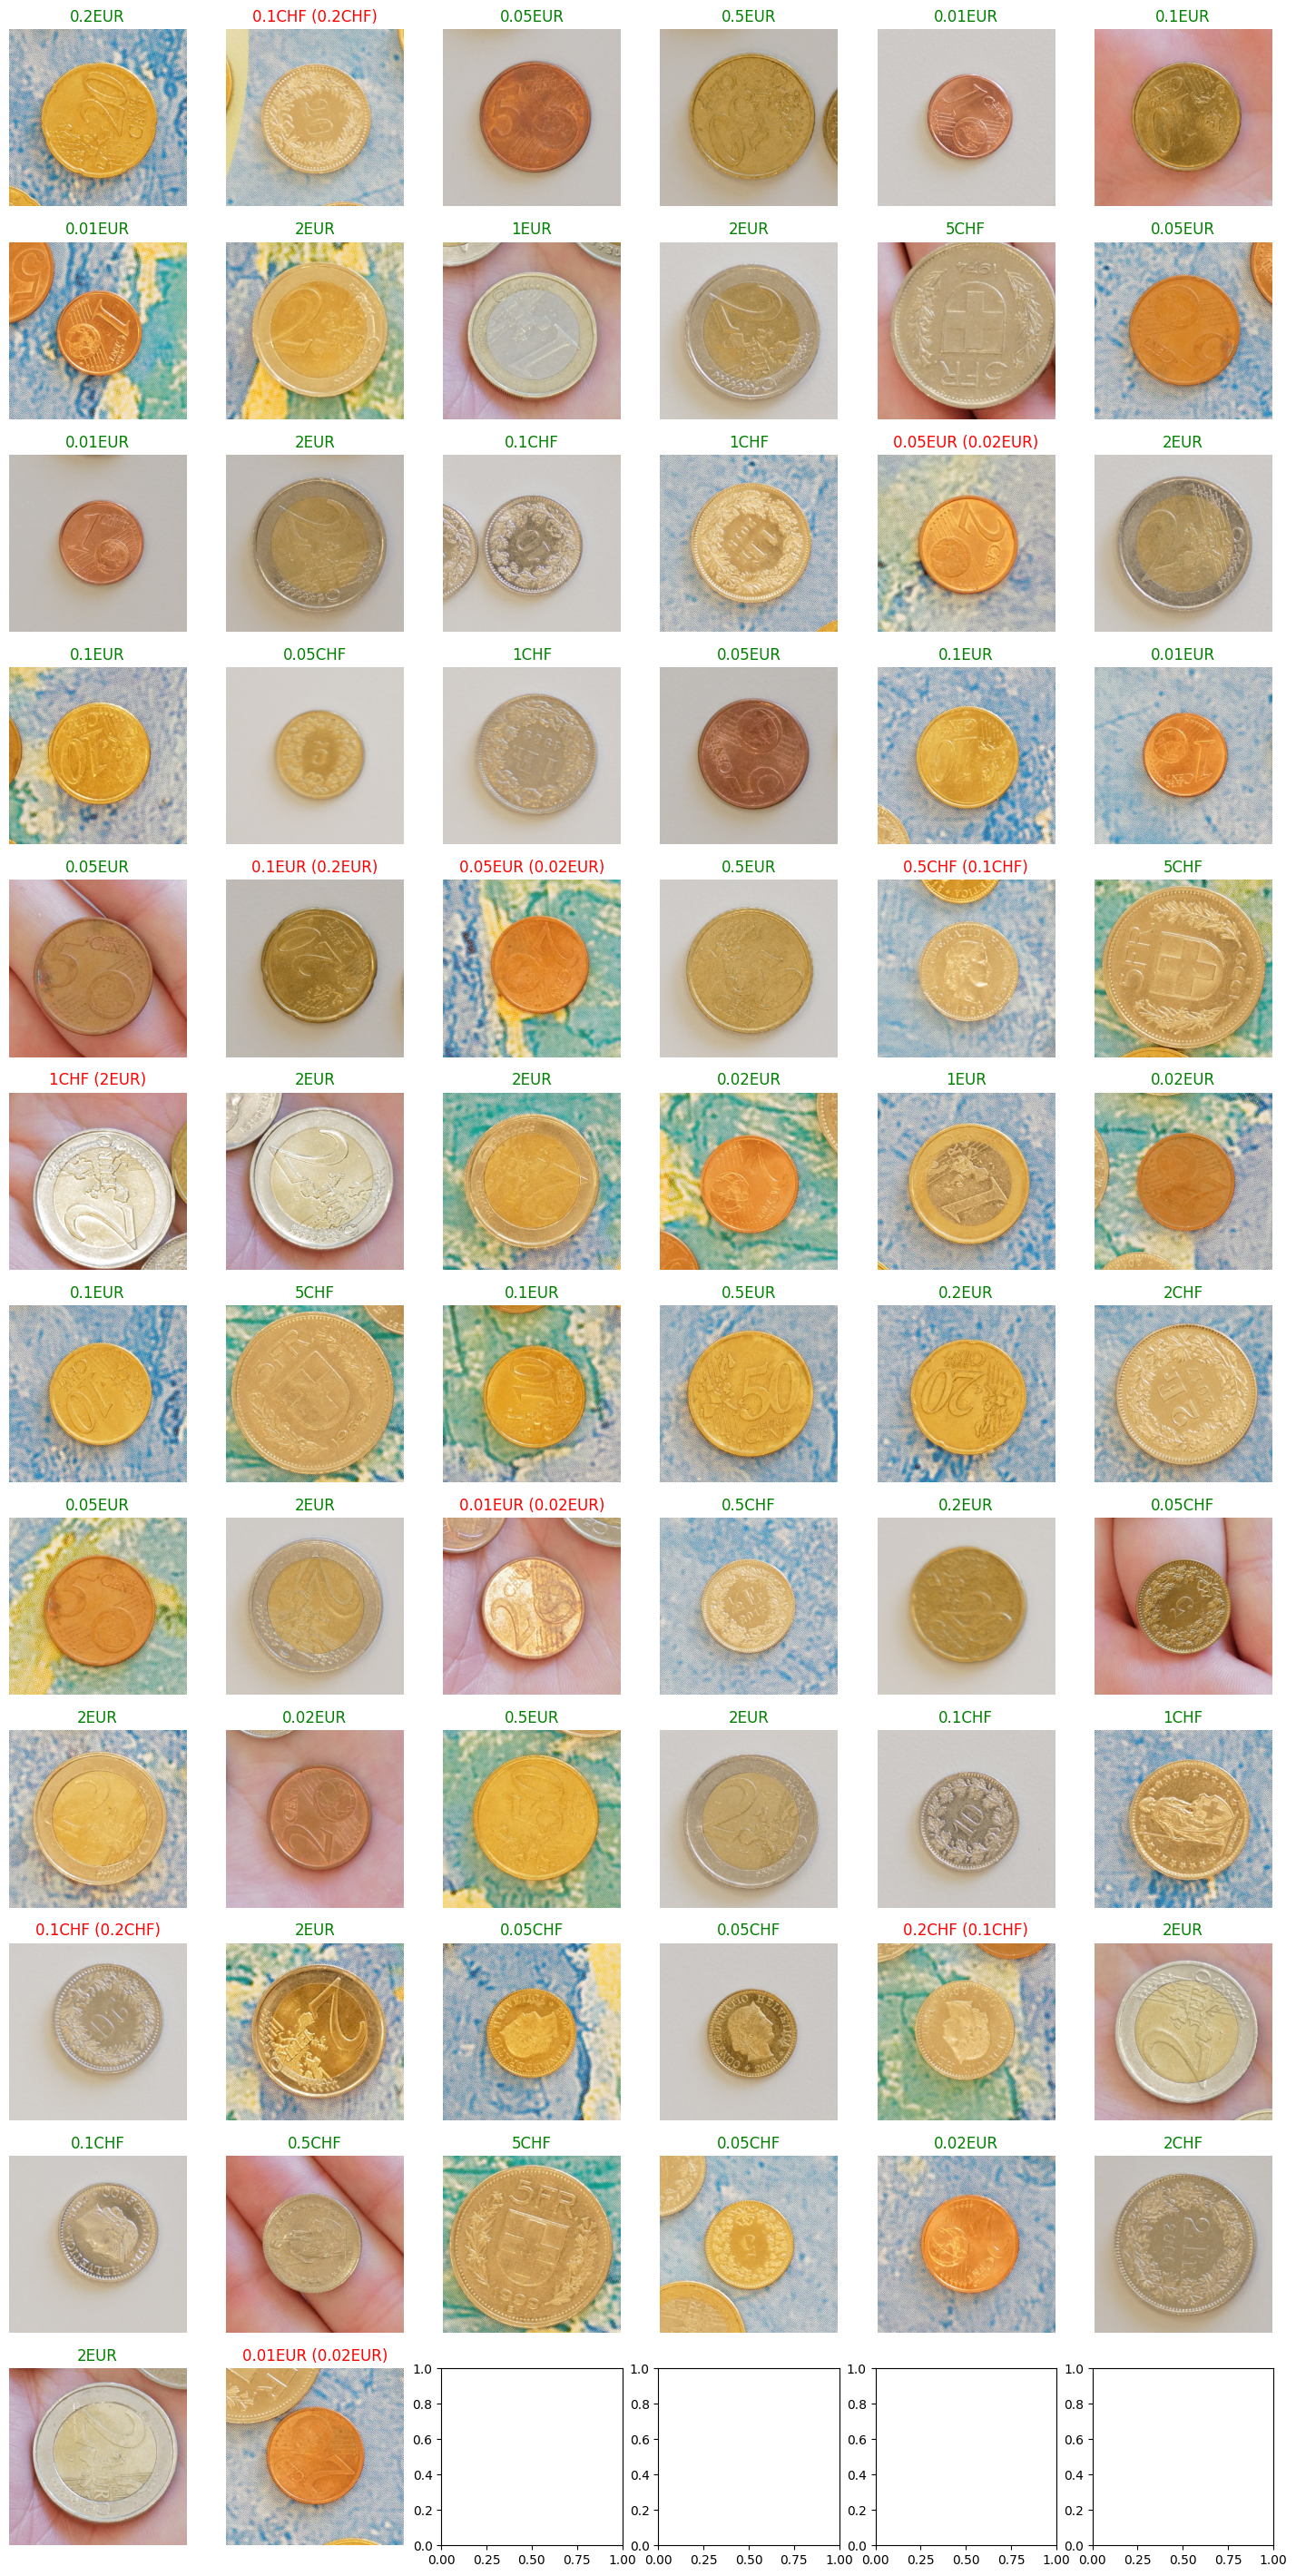

In [ ]:
nbr = None
plot_coins(x_val[0:nbr], y_val[0:nbr], y_pred[0:nbr])